## Import Modules and Libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

## Import CiFAR Dataset
- It is a more advance dataset compared to MNIST
- It has 10 classes 
- The dimension of the images are 32x32x3 since it is a RGB image
- Shown below are the classses in the CiFAR dataset
- Like MNIST, CiFAR also has 50K training images and labels as well as 10K test images and labels

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## Print training data dimensions

In [18]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


## Displaying a sample from each class of the dataset

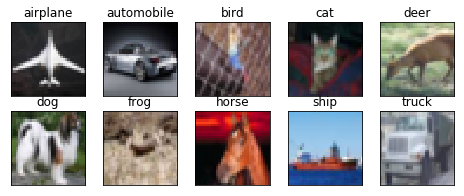

In [19]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Function for plotting accuracy and loss during model training

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Accuracy Calculation for a model

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Data Float Conversion , remapping pixel values between 0 & 1, and One-Hot encoding

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Model Architecture and Compiling Model
- First thing I changed is the model architecture
- I have implemented a model with convolution block, transition block and output block
![](model.png)
- The convolution blocks extract the features from the data while the transition block combine this information in fewer channels and also reduce the size of the model
- The number of layers were added bassed on the Receptive field of the model
- With the below changes in the architecture, I got an accuracy around the base accuraccy 
- Then, I reduced number of kernels to reduce the number of parameters
- Then I added Dropout to reduce the overfitting
- Adding Batch Normalization layer gave the required accuracy within 100 epochs
- **Accuracy of 84.32% was achieved in 87th epoch**

In [0]:
# Define the model
model = Sequential()

drop = 0.35

# Convolution Block
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3))) # Output: 32x32x32    |    Receptive Field: 3x3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, 3, 3, border_mode='same'))                          # Output: 32x32x64    |    Receptive Field: 3x3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, 3, 3, border_mode='same'))                         # Output: 32x32x128    |    Receptive Field: 3x3
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(SpatialDropout2D(drop))

# Transition Block
model.add(MaxPooling2D(pool_size=(2, 2)))                                       # Output: 16x16x128    |    Receptive Field: 6x6
model.add(Convolution2D(64, 1, 1))                                              # Output: 16x16x64     |    Receptive Field: 6x6
model.add(Activation('relu'))
model.add(BatchNormalization())

# Convolution Block
model.add(Convolution2D(64, 3, 3, border_mode='same'))                          # Output: 16x16x64     |    Receptive Field: 6x6
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, 3, 3, border_mode='same'))                         # Output: 16x16x128    |    Receptive Field: 6x6
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(SpatialDropout2D(drop))

# Transition Block
model.add(MaxPooling2D(pool_size=(2, 2)))                                       # Output: 8x8x128      |    Receptive Field: 12x12 
model.add(Convolution2D(64, 1, 1))                                              # Output: 8x8x64       |    Receptive Field: 12x12
model.add(Activation('relu'))
model.add(BatchNormalization())

# Convolution Block
model.add(Convolution2D(64, 3, 3, border_mode='same'))                          # Output: 8x8x64       |    Receptive Field: 12x12
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, 3, 3, border_mode='same'))                         # Output: 8x8x128      |    Receptive Field: 12x12
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(SpatialDropout2D(drop))

# Transition Block
model.add(MaxPooling2D(pool_size=(2, 2)))                                       # Output: 4x4x128      |    Receptive Field: 24x24 
model.add(Convolution2D(64, 1, 1))                                              # Output: 4x4x64       |    Receptive Field: 24x24
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(num_classes, 4, 4))                                     # Output: 1x1x10       |    Receptive Field:  28x28

# Output Block
model.add(Flatten())                                                            
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


W0623 02:54:55.966486 140355499857792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
W0623 02:54:56.008965 140355499857792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 02:54:56.016989 140355499857792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 02:54:56.053943 140355499857792 deprecation_wrapper.py:119] From /usr/local/lib/python3.

## Model Summary

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
__________

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

from keras.callbacks import ModelCheckpoint

# Link to store models
filepath="/content/gdrive/My Drive/Colab Notebooks/Training-9/model-{epoch:02d}-{val_acc:.2f}.hdf5"

# Configuration of Modelcheckpoint to save only best models
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

## CutOut

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

## Model Training and progress tracking

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  from ipykernel import kernelapp as app
W0623 02:57:18.556001 140355499857792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (


Epoch 00001: val_acc improved from -inf to 0.50190, saving model to /content/gdrive/My Drive/Colab Notebooks/Training-9/model-01-0.50.hdf5

Epoch 00002: val_acc improved from 0.50190 to 0.60800, saving model to /content/gdrive/My Drive/Colab Notebooks/Training-9/model-02-0.61.hdf5

Epoch 00003: val_acc improved from 0.60800 to 0.65670, saving model to /content/gdrive/My Drive/Colab Notebooks/Training-9/model-03-0.66.hdf5

Epoch 00004: val_acc improved from 0.65670 to 0.70580, saving model to /content/gdrive/My Drive/Colab Notebooks/Training-9/model-04-0.71.hdf5

Epoch 00005: val_acc improved from 0.70580 to 0.73030, saving model to /content/gdrive/My Drive/Colab Notebooks/Training-9/model-05-0.73.hdf5

Epoch 00006: val_acc did not improve from 0.73030

Epoch 00007: val_acc improved from 0.73030 to 0.74660, saving model to /content/gdrive/My Drive/Colab Notebooks/Training-9/model-07-0.75.hdf5

Epoch 00008: val_acc improved from 0.74660 to 0.75990, saving model to /content/gdrive/My Dri

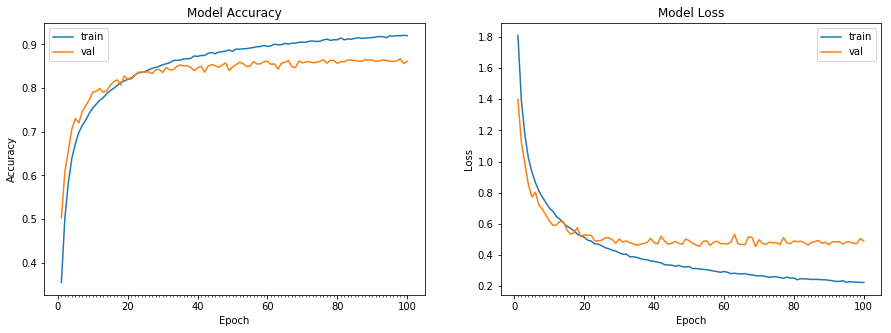

Accuracy on test data is: 86.16


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), 
                                 verbose=0, 
                                 callbacks=[checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## Before Cutout: 84.32% - (87th Epoch)
## After Cutout: 86.71 % - (98th Epoch)

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
from google.colab.patches import cv2_imshow
import random

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
from keras.models import load_model

filepath="/content/gdrive/My Drive/Colab Notebooks/Training-9/model-98-0.87.hdf5"

model = load_model(filepath)

W0624 18:06:45.654237 140388946499456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 18:06:45.703228 140388946499456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 18:06:45.746803 140388946499456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 18:06:45.748320 140388946499456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0624 18:06:45.750712 140388946

In [0]:
# from keras.datasets import cifar10
# (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

In [0]:
def disp(x):
  x = cv2.resize(x, (200,200))
  cv2_imshow(x)

In [0]:
def viz(input_img, layer_name, channel_number):
  x = image.img_to_array(input_img)
  x = preprocess_input(x)
  x = np.expand_dims(x, axis=0)
  
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_name)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(channel_number):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = np.asarray(heatmap, np.float32)
  superimposed_img = cv2.addWeighted(input_img, 0.6, heatmap, 0.4, 0)
  
  return superimposed_img

Activation Image - 1 : 


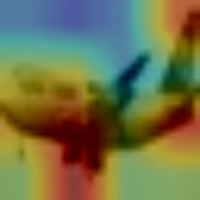

Activation Image - 2 : 


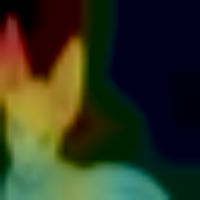

Activation Image - 3 : 


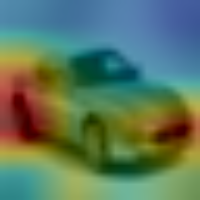

Activation Image - 4 : 


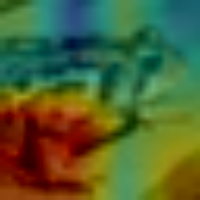

Activation Image - 5 : 


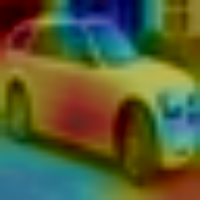

Activation Image - 6 : 


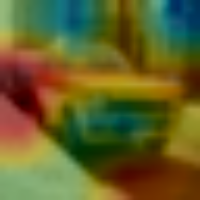

Activation Image - 7 : 


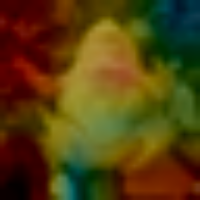

Activation Image - 8 : 


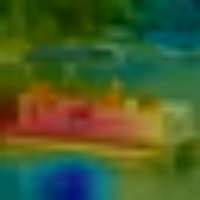

In [14]:
imgs_indx = [4305, 2840, 8990, 6330, 2450, 1134, 1094, 8159]

# GradCam activation image
for i in range(len(imgs_indx)):
  preprocess_img = image.img_to_array(test_features[imgs_indx[i]])
  preprocess_img = cv2.cvtColor(preprocess_img, cv2.COLOR_BGR2RGB)
  out = viz(preprocess_img, layer_name="conv2d_10", channel_number=10)
  print("Activation Image -", i+1, ": ")
  disp(out)

### Results

![](Data/1-4.png)
![](Data/5-8.png)


- In above images, 6A model is a model trained earlier on CiFar-10 dataset
- In 9B model, 6A model is trained with an augmentation technique called Cutout.
- In cutout, we randomly drop portion of an image and cover it with a patch
- The color of this patch is equal to the mean color value of the image
- Comparing 6A and 9B, it is clear that the model started focusing more at the object due to the use of cutout augmentation technique

---